# Examining gender representation in American diplomacy overtime

This project utilizes a data extraction, cleaning, and analysis pipeline to to examine and visualize gender representation in the State Department directories in 1965, 1982, and 2022.

For more on background and discussion of results, refer the README file.

### Table of contents

1. Initialize project
2. Define functions
3. Run pipeline
4. Classify
5. Visualize

## Initialize project

In [27]:
import pandas as pd
import numpy as np
import re
import pymupdf
import nameparser
from nameparser import HumanName
from nameparser.config import Constants
import gender_guesser
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# ensure your current working directory is dos-diversity
import os
os.getcwd()

'/Users/ellicehuang/Desktop/data projects/dos-diversity'

In [29]:
# ignore regex warnings
import warnings
warnings.filterwarnings('ignore')

## Define pipeline functions
These 6 functions extract and clean offcer ranks and names from a source PDF.

1. `import_pdf` extracts data from the PDF and save in a dataframe.
2. `remove_indices` filters out introductory information, indices, and appendices.
4. `remove_addresses` filters out rows that contain embassies, countries, etc.
5. `find_format` filters for rows that take the format of 'RANK: First M. Last' or 'RANK First M. Last'
6. `separate_rankname` separates the RANK and First M. Last into separate columns.
7. `split_firstlast` separates officer name into title, first, middle, last, suffix

In [30]:
def import_pdf(filename):
    """Extract data from the PDF into a dataframe.

    Parameters
    ----------
    filename : str
        The file name in 'YYYY_MMM' format

    Returns
    -------
    dataframe
        A dataframe with two columns: 'text' is the raw text, and 'text_squish' is
        the raw text with stripped whitespace.
    """
    
    with pymupdf.open('inst/' + filename + '.pdf') as doc:
        text = ''
        for page in doc:
            text += page.get_text()
        text = text.split('\n')
    
    df = pd.DataFrame({'text':text,
                       'text_squish':0})
    
    df.text_squish = df.text.str.strip()

    # drop empty columns
    df = df.dropna()
    df = df[df.text_squish != ''].reset_index(drop=True)
    
    return df

def remove_indices(df):
    """Filter out introductory information, indices, and appendices.

    The first country is generally Algeria or Afghanistan. The last country is 
    generally followed by an "Abbreviations and Symbols" or "Geographical Index" 
    section. 
    """
    
    # To find the beginning index: check which row contains an Algeria or 
    # Afghanistan section.
    algeria = df.loc[df.text.str.fullmatch('ALGERIA')].index
    algeria = algeria[0] if len(algeria) > 0 else 0
    afgh = df.loc[df.text.str.fullmatch('AFGHANISTAN')].index
    afgh = afgh[0] if len(afgh) > 0 else 0
    
    # If both exist, take the smaller value.
    start = afgh if afgh != 0 and afgh < algeria else algeria
    print('Start index: ' + str(start))
    
    # To find the end index: check which row contains a "Abbreviations and Symbols" 
    # or "Geographical Index" section.
    abbrev = df.loc[df.text.str.fullmatch('ABBREVIATIONS AND SYMBOLS')].index
    abbrev = abbrev[0] if len(abbrev) > 0 else df.shape[0]
    geog = df.loc[df.text.str.fullmatch('GEOGRAPHICAL INDEX')].index
    geog = geog[0] if len(geog) > 0 else df.shape[0]

    # If both exist, take the smaller value.
    end = geog if geog < abbrev else abbrev

    # If neither sections exist. assign the length of the dataframe.
    end = df.shape[0] if end == 0 or end < start else end
    print('End index: ' + str(end))
    
    df = df.iloc[start:end,:].reset_index(drop=True)
    
    return df

"""
Create `countries_regex` to filter out rows with country names 
in title case, capital case, or abbreviated
"""
import iso3166
from iso3166 import countries
countries_title = pd.Series(iso3166.countries_by_name.keys()).str.title()
countries_caps = list(iso3166.countries_by_name.keys())
countries = list(countries_title)+countries_caps
countries_regex = "(" + ")|(".join(countries) + ")"

def remove_addresses(df):
    """Filter out rows that contain addresses, countries, page numbers, etc.

    Dummy code addresses, countries, embassies, consulates, consulate generals,
    page numbers, and pages. Remove from dataframe.
    """
    
    df['address'] = df.text_squish.str.contains(r'B.P. Box|P.O. Box|Tel|Workweek|Telex|\d{5}|FAX',
                                                regex=True).astype(int)
    df['country'] = df.text_squish.str.contains(countries_regex, regex=True).astype(int)
    df['embassy'] = df.text_squish.str.contains(r'\(E\)|EMBASSY', regex=True).astype(int)
    df['consulate'] = df.text_squish.str.contains(r'\(C\)', regex=True).astype(int)
    df['consgen'] = df.text_squish.str.contains(r'\(CG\)', regex=True).astype(int)
    df['pagenum'] = df.text_squish.str.contains(r'#{10,}', regex=True).astype(int)
    df['page'] = df.text_squish.str.fullmatch(r'\d*').astype(int)
        
    df = df.loc[(df.address==0) & 
                (df.country==0) &
                (df.embassy==0) & 
                (df.consulate==0) &
                (df.consgen==0) & 
                (df.pagenum==0) &
                (df.page==0),
                ['text','text_squish']].reset_index(drop=True)
    
    return df

def find_format(df, form):
    """Filters dataframe for rows that take the format of 'RANK: First M. Last'
    or 'RANK First M. Last'

    If there is a rank label at the end of the line and no following name,
    join it with the following line. Then, delete rows without the format.

    Parameters
    ----------
    form : {0, 1}
        The format to be used. 
        - 0: RANK: First M. Last
        - 1: RANK First M. Last
        
    Example
    ----------
    >>> df
        text_squish
    0	AMB:
    1	John A. Doe

    >>> find_format(df, 0)
        text_squish
    0   AMB: John A. Doe
    """

    # if the line ends with RANK, join it with the following line.
    if form == 0: # format: 'RANK: First M. Last'
        df['join'] = df.text_squish.str.contains(r'[A-Z ]+[\s:|;|.]$', regex=True)

    elif form ==1: # format: 'RANK First M. Last'
        df['join'] = df.text_squish.str.contains(r'[A-Z ]{2,}$', regex=True)

    joinedlist = []
    for i in range(0, len(df.text_squish)):
        
        if df['join'][i] == True and i != len(df.text_squish) - 1:
            a = list(df.text_squish)[i]
            b = list(df.text_squish)[i + 1]
            joined = a + ' ' + b
            joinedlist += [joined]
            
        else:
            joinedlist += [list(df.text_squish)[i]]
    
    df['text_joined'] = joinedlist
    
    # delete rows without the format 'RANK: First M. Last' or 'RANK First M. Last'
    if form == 0:
        df['text_clean'] = df.text_joined.str.contains(r'^[A-Z ]{2,}[:;,.]\s[A-Za-z\. ]*', regex=True)
        
    elif form ==1:
        df['text_clean'] = df.text_joined.str.contains(r'^[A-Z ]{2,}\s[A-Za-z\. ]*$', regex=True)
        
    df = df[df['text_clean']][['text','text_squish','text_joined']].reset_index(drop=True)
    
    return df

def separate_name(df, form):
    """Separates name into title, first, middle, last, suffix

    Parameters
    ----------
    form : {0, 1}
        The format to be used. 
        - 0: 'RANK: First M. Last'
        - 1: 'RANK First M. Last'
        
    Example
    ----------
    >>> df
        text_joined
    0	AMB: John A. Doe
        
    >>> separate_name(data, 0)
        rank	name
    0	AMB	    John A. Doe
    """

    if form == 0:
        # RANK can be followed by ':', ';', or '.'. Only split on the first instance.
        a = df['text_joined'].str.split(r'([A-Z\ ]{2,})[:;.]', n=1, expand=True)

        if len(a.columns)>3:
            ranks = list(a[1]) + list(a[3])
            namelist = list(a[2]) + list(a[4])
        elif len(a.columns)==3:
            ranks = a[1]
            namelist = a[2]

    elif form == 1:
        a = df['text_joined'].str.extract(r'([A-Z/\s]{2,})[\s\.:;](.*)', expand=True)
        ranks = a[0]
        namelist = a[1]
        
    df['rank'] = ranks
    df['name'] = namelist
    
    df = df.dropna().reset_index(drop=True)
    
    return df

def split_firstlast(df):
    """Extracts first and last name from listed name.

    Uses name_parser package. Add "Ambassador" and "Attache" to the list
    of titles to parse. If the first name is an initial, use middle name
    as first. 
    """
    
    # add amb to titles
    constants = Constants()
    constants.titles.add('amb')
    constants.suffix_not_acronyms.add('attache')
    
    # separate names to title, first, mid, last, suff
    titles = []
    firsts = []
    mids = []
    lasts = []
    suffs = []
    for name in df.name:
        parse = HumanName(name, constants=constants)
        titles += [parse.title]
        firsts += [parse.first]
        mids += [parse.middle]
        lasts += [parse.last]
        suffs += [parse.suffix]
    df['title'] = titles
    df['first'] = firsts
    df['middle'] = mids
    df['last'] = lasts
    df['suffix'] = suffs

    # if first name is an initial -> use middle name
    df['first_clean'] = ''
    for index in range(0,len(df['first'])):
        name = df.loc[index, 'first']
        middle = df.loc[index, 'middle']

        if re.match(r'[A-Z]\.', name) is not None:
            df.loc[index, 'first_clean'] = middle
        else:
            df.loc[index, 'first_clean'] = name
                    
    # finally, merge first and last to new column firstlast
    df['firstlast'] = df['first_clean'] + ' ' + df['last']
    df = df.loc[(df['firstlast']!=' ')]
    
    # and drop duplicates and missing full names
    df = df.drop_duplicates(['rank','name']).reset_index(drop=True)
    df = df.loc[(df['first']!='')].reset_index(drop=True)
    
    return df

<a name = "run"></a>
## Run pipeline

In [31]:
# create empty dataframe to store combined data
combined = pd.DataFrame(columns=['year','rank','name','first_clean','middle','last','firstlast'])

for file in ['1965_Feb.pdf', '1982_Jan.pdf', '2022_Oct.pdf']:

    filename = re.split('.pdf', file)[0]
    year = filename.split('_')[0]
    print('Scraping year: ' + str(year))

    # pipeline
    df = import_pdf(filename)
    df = remove_indices(df)
    df = remove_addresses(df)
    
    if (year == '1965') | (year == '1982'): # takes the form RANK: First M. Last
        df = find_format(df, 0)
        df = separate_name(df, 0)
    
    elif year == '2022': # takes the form RANK First M. Last
        df = find_format(df, 1)
        df = separate_name(df, 1)
    
    df = split_firstlast(df)

    # combine new data with previously existing
    df['year'] = year
    df = df[['year','rank','name','first_clean','middle','last','firstlast']]
    
    combined = pd.concat([combined, df])

combined.to_csv('clean/clean_combined.csv', index=False)

Scraping year: 1965
Start index: 94
End index: 1432
Scraping year: 1982
Start index: 914
End index: 7326
Scraping year: 2022
Start index: 0
End index: 14568


## Classify genders of first names

In [36]:
def guess_gender(df):
    """Classifies the genders of a given column of names in a dataframe.

    Uses gender_guesser package. Returns dataframe with new column 'gender_guess'
    containing 'male', 'mostly_male', 'female', 'mostly_female', 
    'andy' (androgynous), or 'unknown' values.
    """
    
    d = gender.Detector()

    genderlist = []
    for name in df.first_clean:
        genderlist += [d.get_gender(name)]
    df['gender_guess'] = genderlist
    
    return df

def get_gender_stats(df):
    """Generates summary statistics for a dataframe with a column of gender categories
    from the gender_guesser package.

    Combines 'mostly_female' with 'female', and 'mostly_male' with 'male'. Gives the 
    gender percentage, both including and excluding unknowns.
    """
    
    df.loc[df['gender_guess']=='mostly_male','gender_guess']='male'
    df.loc[df['gender_guess']=='mostly_female','gender_guess']='female'

    # get statistics
    counts = classified.groupby(['year', 'gender_guess']).count()[['name']].reset_index().set_index('year')
    counts = counts.rename(columns = {'name': 'count'})

    # get totals
    totals = classified.groupby(['year']).count()[['name']]
    totals['gender_guess'] = 'total'
    totals = totals.rename(columns = {'name': 'count'})

    # get known totals
    known = totals['count'] - counts[counts['gender_guess']=='unknown']['count']
    known = pd.DataFrame(known)
    known['gender_guess'] = 'known'

    # combine
    gender = pd.concat([counts, totals, known]).sort_index()
    gender.columns = ['category','count']

    # calculate percentages
    gender['total_percent'] = gender['count'] / gender.join(totals, rsuffix='_total')['count_total']
    gender['total_percent'] = round(gender['total_percent'], 3)
    
    gender['known_percent'] = gender['count'] / gender.join(known, rsuffix='_known')['count_known']
    gender['known_percent'] = round(gender['known_percent'], 3)
    
    return gender

In [33]:
classified = guess_gender(combined)
stats = get_gender_stats(classified)
stats

,category,count,total_percent,known_percent
year,,,,
1965,andy,1,0.001,0.002
1965,female,23,0.030,0.035
1965,male,628,0.821,0.963
1965,unknown,113,0.148,0.173
1965,known,652,0.852,1.000
1965,total,765,1.000,1.173
1982,andy,1,0.001,0.001
1982,female,121,0.075,0.079
1982,male,1409,0.872,0.920


## Visualize

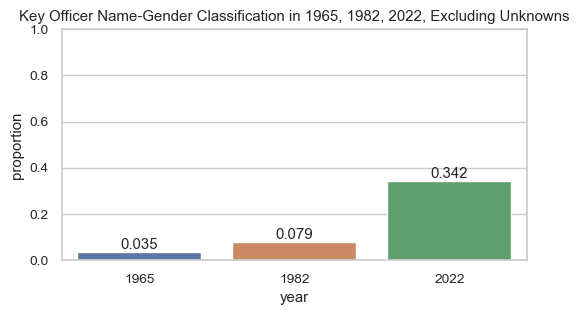

In [34]:
# Visualize percent of (known) female classifications overtime
compare_female = stats[stats['category']=='female']

plt.figure(figsize=(6,3))
sns.set(style='whitegrid', font_scale=0.9)
plot = sns.barplot(data=compare_female, x='year', y='known_percent',
                   hue="year")
plot.set(title='Key Officer Name-Gender Classification in 1965, 1982, 2022, Excluding Unknowns', ylim=(0,1),
         ylabel='proportion');
for i in plot.containers:
    plot.bar_label(i,);

plt.savefig('images/barplot.png', bbox_inches="tight", dpi=100)

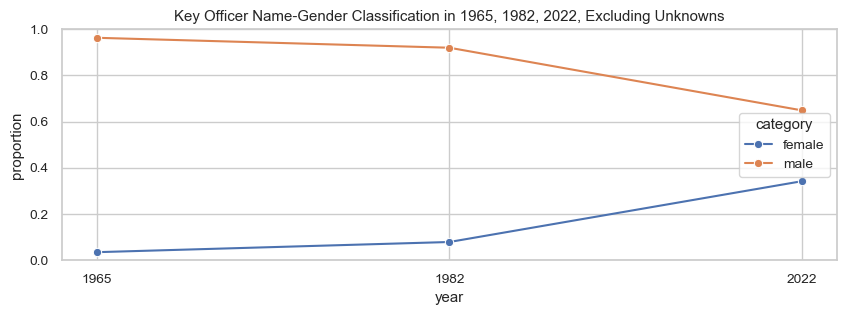

In [35]:
# Alternative visualization: line plot
plt.figure(figsize=(10,3))
sns.set(style='whitegrid', font_scale=0.9)
plot = sns.lineplot(data=stats[(stats['category']=='male')|(stats['category']=='female')], 
                    x='year', y='known_percent', hue='category', marker='o')
plot.set(title='Key Officer Name-Gender Classification in 1965, 1982, 2022, Excluding Unknowns', ylim=(0,1),
         ylabel='proportion');
plt.savefig('images/lineplot.png', bbox_inches="tight", dpi=100)